[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Mate_MercadosFinancieros/blob/main/Semana4_OpcionesAmericanas.ipynb)

# Cargar librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones

#### simula_precios()

In [ ]:
def simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias):
    '''La función regresa un dataframe donde cada renglón corresponde a la
    simulación de la trayectoria del precio, bajo la hipótesis de que el precio
    del activo sigue un Movimiento Browniano Geométrico, comenzando por el
    precio inicial en t = 0,  en la primer columna y t = T en la última.

    * precio_inicial: Precio inicial del activo, cuando se firma la opción
    * tasa_interes: Tasa de interes considerada para la vigencia de la opción
    * sigma: volatilidad (desviación estándar) del precio del activo en un
             periodo anterior
    * T: vigencia en días de la opción
    * trayectorias: número de simulaciones de la trayectoria del precio'''

    # Creamos una matriz de  ceros de tamaño T+1, trayectorias.
    np.random.seed(1)
    MatrizPrecios = np.zeros((trayectorias, T + 1), dtype = np.float64)
    # Colocamos en el primer renglón(dia0) el precio inicial
    MatrizPrecios[:,0] = precio_inicial



    #Movimiento Brawniano Geométrico para calcular el valor del precio en cada t a partir de t =|
    for i in range(1, T + 1):
        #partimos de una variable aleatoria distribución normal en cada una de las trayectorias a simular
        Z = np.random.standard_normal(size = trayectorias)
        weiner_process = sigma * Z / np.sqrt(365)  #weiner_process o movimiento browniano
        MatrizPrecios[:, i] = (MatrizPrecios[:, i - 1] * np.exp((tasa_interes - sigma ** 2 / 2.) * 1 / 365 + weiner_process ))  # ec. (1.5) Gustafsson (2015)

    return pd.DataFrame(MatrizPrecios,  index=['simulacion_'+ str(row) for row in range(1, trayectorias+1)])


#### LSM()

In [ ]:
def LSM(precio_inicial, tasa_interes, sigma, T, trayectorias, precio_strike, tipo ='put'):
    ''' La funcion calcula el valor de una opción. Par ello,  llama a la función
    simula_precios para generar las trayectorias de precios del activo, insumo
    para calcular escenarios de ganancias a obtener considerando el precio de
    ejercicio o strike. Finalmente se construye una matriz de valor calculando
    la esperanza condicionada de la ganancia por mantener viva la opción en cada
    oportunidad de ejercicio a partir de una regresión polinomial por mínimos cuadrados.'''

    assert tipo == 'call' or tipo == 'put', "el tipo de opción solo puede ser 'call' o 'put'"

    # Paso 1. Creación de Matriz de Precios
    df_precios = simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias)
    MatrizPrecios = df_precios.values

    # PASO 2. Creación de Matriz de Ganancias
    if tipo == 'call':
       Ganancia = np.maximum(MatrizPrecios - precio_strike,
                             np.zeros((trayectorias, T + 1),dtype=np.float64))
    elif tipo == 'put':
       Ganancia = np.maximum(precio_strike - MatrizPrecios,
                              np.zeros((trayectorias, T + 1),dtype=np.float64))

    # PASO 3. Creación de Matriz de Valor
    MatrizValor = np.zeros_like(Ganancia)
    MatrizValor[:,-1] = Ganancia[:,-1]

    # Regresión polynomial por mínimos cuadrados (orden 2)
    descuento = np.exp(-tasa_interes*T/365)
    for t in range(T - 1, 0 , -1):
        coeficientes = np.polyfit(MatrizPrecios[:, t],MatrizValor[:, t + 1] * descuento, 2)
        valor_continuar = np.polyval(coeficientes, MatrizPrecios[:, t])
        # Se evaluá si la Ganancia resulta mayor que el valor de continuar
        MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                     Ganancia[:, t], MatrizValor[:, t + 1] * descuento)
    # PASO 4. El valor de la opción se evalua en el tiempo 0 de la Matriz Valor

    valor_opcion_t0 = MatrizValor[:,1]*descuento
    return  np.mean(valor_opcion_t0)

# Leer y explorar serie de precios

In [ ]:
#importar precios café 2020 obtenidos de Yahoo Finance

precio = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LSM-Opciones-americanas/main/Datos/Precios%20Azucar%202020.csv',
                     usecols=['Date', 'Close'], parse_dates=['Date'], index_col = 'Date').dropna()
precio = precio['Close']
precio

,Close
Date,
2020-01-02,13.13
2020-01-03,13.31
2020-01-06,13.73
2020-01-07,13.59
2020-01-08,13.47
2020-01-09,13.71
2020-01-10,14.07
2020-01-13,14.16
2020-01-14,14.32


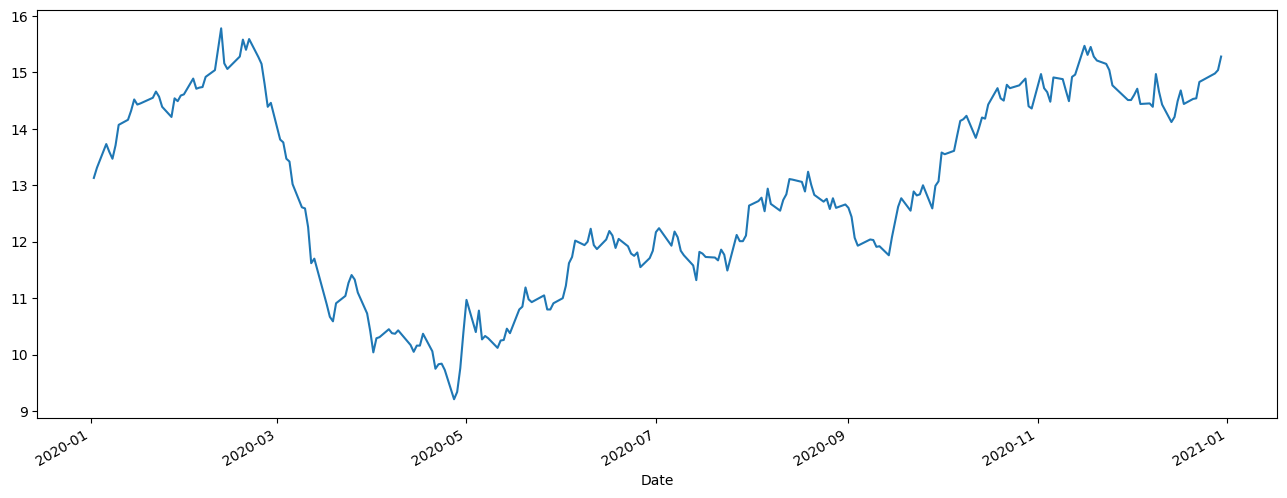

In [ ]:
#visualizar serie
precio.plot(figsize=(16,6))
plt.show()

#Simulación Monte Carlo trayectorias de precio a un año
tasa de interés 6%

In [ ]:
precio_ini = precio[-1]
sigma = np.std(precio)

precio_ini, sigma

<ipython-input-8-6c0fb5a1e807>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  precio_ini = precio[-1]


(15.28, 1.680237866970031)

In [ ]:
#considerando la misma cantidad de días que en 2020 hacemos la simulación Montecarlo de un proceso Browniano
tasa = 0.06
dias = 30
n = 150000


Precios_df = simula_precios(precio_ini, tasa, sigma , dias, n  )
Precios_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
simulacion_1,15.28,17.561327,16.231503,16.597065,16.680372,15.537294,15.960361,17.325719,20.336025,22.514823,...,22.492421,22.597242,26.401440,27.969662,28.016856,28.659543,29.699588,32.871778,27.848593,29.511507
simulacion_2,15.28,14.426102,15.506855,14.123505,13.364882,14.108793,15.143849,15.091583,12.946440,12.651010,...,9.231304,8.560340,7.987191,7.693249,7.757886,7.262922,6.800958,6.668809,7.517860,6.773376
simulacion_3,15.28,14.532540,15.991096,15.531001,13.844871,13.644119,14.104036,13.229828,13.652552,13.188685,...,17.341956,18.667045,17.475841,19.019439,19.222673,19.631608,19.249886,21.289730,23.225997,24.254033
simulacion_4,15.28,13.852652,12.822144,13.719303,13.364764,14.803389,16.156495,15.981509,16.291039,16.079470,...,13.934084,14.033176,14.329727,14.252236,12.936798,11.989991,14.931941,16.558487,21.268675,18.864235
simulacion_5,15.28,16.427428,15.665354,17.728493,15.049232,14.900170,13.983552,13.031052,14.452635,16.084611,...,6.561264,6.335870,5.565021,6.060038,5.607180,4.658791,5.249767,5.278541,4.727568,5.432962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulacion_149996,15.28,14.087027,12.126533,11.618523,12.334194,11.796876,11.615107,11.412306,10.900237,14.799714,...,6.387396,6.685755,6.259263,6.150894,6.241907,5.975696,6.365051,6.071113,5.206422,4.780215
simulacion_149997,15.28,15.596889,14.900218,14.519553,13.676196,14.192995,13.817127,13.766385,14.516640,11.703306,...,8.782320,8.911542,8.651974,8.395797,9.483373,11.907212,11.925066,11.145515,10.409914,12.111319
simulacion_149998,15.28,13.944811,14.213770,13.659506,15.019265,15.473107,15.268104,14.393948,13.815025,13.489066,...,8.667522,8.124743,7.532588,7.430078,6.970608,6.354635,6.960693,6.425539,6.409292,6.477771
simulacion_149999,15.28,13.993963,14.475954,17.150135,16.931046,16.920038,16.835497,16.804310,16.781108,16.252710,...,11.313708,10.853041,10.011382,10.163345,10.390218,8.887057,8.557226,7.557117,7.617498,6.750637


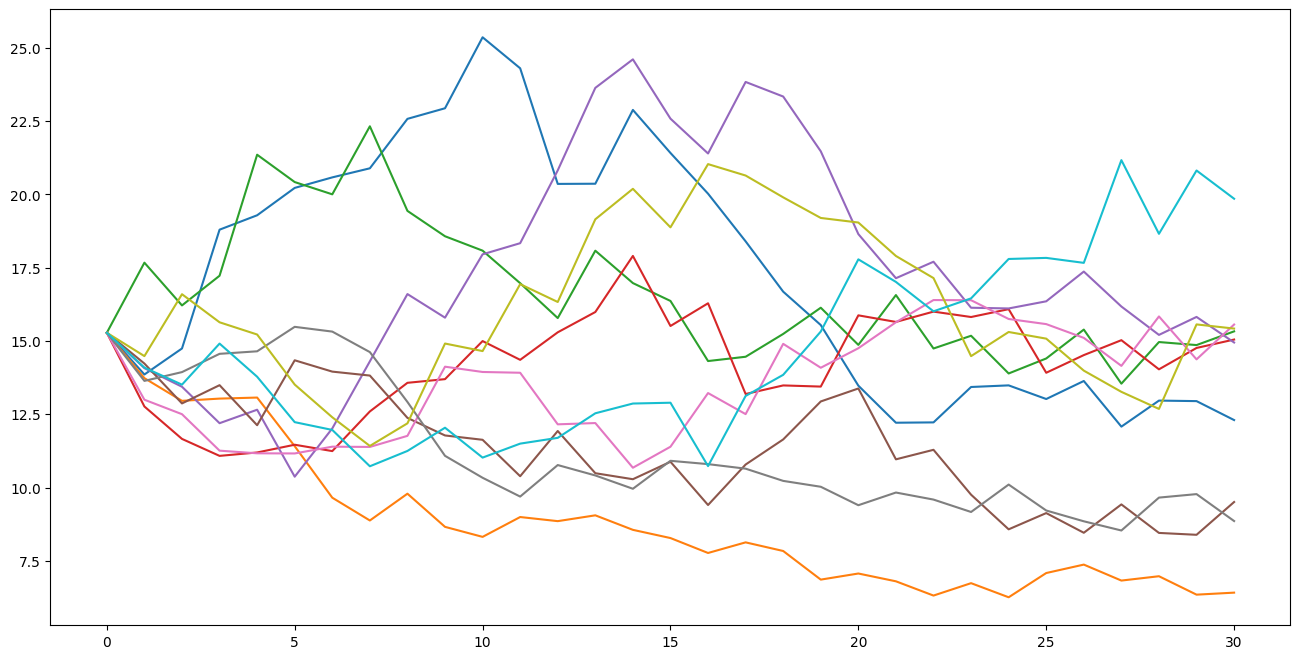

In [ ]:
muestra = np.random.choice(Precios_df.index, 10)
Precios_df.transpose()[muestra].plot(figsize=(16, 8), legend=False)
plt.show()

# Construcción de la Matriz de Ganancias

In [ ]:
Precios_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
simulacion_1,15.28,17.561327,16.231503,16.597065,16.680372,15.537294,15.960361,17.325719,20.336025,22.514823,...,22.492421,22.597242,26.401440,27.969662,28.016856,28.659543,29.699588,32.871778,27.848593,29.511507
simulacion_2,15.28,14.426102,15.506855,14.123505,13.364882,14.108793,15.143849,15.091583,12.946440,12.651010,...,9.231304,8.560340,7.987191,7.693249,7.757886,7.262922,6.800958,6.668809,7.517860,6.773376


In [ ]:
# Calcular Matriz de ganancias para opciones "put"
# 0 si el precio es mayor o igual al strike
Strike = 14
Ganancia = np.maximum(Strike - Precios_df.values, np.zeros((n, dias + 1),dtype=np.float64))
pd.DataFrame(Ganancia, index = Precios_df.index).iloc[:, -5:]

,26,27,28,29,30
simulacion_1,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,6.737078,7.199042,7.331191,6.482140,7.226624
simulacion_3,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,2.010009,0.000000,0.000000,0.000000,0.000000
simulacion_5,9.341209,8.750233,8.721459,9.272432,8.567038
...,...,...,...,...,...
simulacion_149996,8.024304,7.634949,7.928887,8.793578,9.219785
simulacion_149997,2.092788,2.074934,2.854485,3.590086,1.888681
simulacion_149998,7.645365,7.039307,7.574461,7.590708,7.522229
simulacion_149999,5.112943,5.442774,6.442883,6.382502,7.249363


# Construcción de la Matriz de Valor

In [ ]:
MatrizValor = np.zeros_like(Ganancia)
MatrizValor[:, -1] = Ganancia[:, -1]  #empezamos en el ultimo día
descuento = np.exp(-tasa*dias/365)

#Regresión polynomial por mínimos cuadrados para calcular el valor de continuar
for t in range(dias-1, 0 , -1): #desde el penúltimo día
    x = Precios_df.iloc[:,t]
    y = MatrizValor[:, t + 1] * descuento
    #encuentra los coeficientes
    coeficientes = np.polyfit(x, y , 2)
    valor_continuar = np.polyval(coeficientes, x)
    #Cuando la ganancia en el tiempo t sea mayor que el valor de continuar,
    MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                  Ganancia[:, t],
                                  MatrizValor[:, t + 1] * descuento)

pd.DataFrame(MatrizValor, index = Precios_df.index)#.iloc[:, -5:]

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
simulacion_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,0.0,4.320810,4.342171,4.363637,4.385209,4.406888,4.428675,4.450569,4.472571,4.494682,...,4.768696,5.439660,6.012809,6.306751,6.242114,6.737078,7.199042,7.331191,6.482140,7.226624
simulacion_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_5,0.0,5.494485,5.521648,5.548946,5.576378,5.603946,5.631650,5.659491,5.687470,5.715587,...,7.438736,7.664130,8.434979,7.939962,8.392820,9.341209,8.750233,8.721459,9.272432,8.567038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulacion_149996,0.0,4.475254,4.497378,4.519611,4.541955,4.564409,4.586974,4.609651,4.632439,4.655341,...,7.612604,7.314245,7.740737,7.849106,7.758093,8.024304,7.634949,7.928887,8.793578,9.219785
simulacion_149997,0.0,4.166365,4.186962,4.207661,4.228462,4.249366,4.270374,4.291485,4.312701,4.334022,...,5.217680,5.088458,5.348026,5.604203,4.516627,1.851790,1.860945,1.870145,1.879390,1.888681
simulacion_149998,0.0,4.355654,4.377187,4.398826,4.420573,4.442427,4.464389,4.486459,4.508639,4.530928,...,5.332478,5.875257,6.467412,6.569922,7.029392,7.645365,7.039307,7.574461,7.590708,7.522229
simulacion_149999,0.0,4.519890,4.542234,4.564690,4.587256,4.609934,4.632724,4.655627,4.678643,4.701773,...,4.988412,5.013073,5.037857,5.062762,5.087791,5.112943,5.442774,6.442883,6.382502,7.249363


In [ ]:
valor_opcion_t0 = np.mean(MatrizValor[:,1]*descuento)
valor_opcion_t0

1.8417937871667753

# Todo junto

In [ ]:
precio_ini, Strike, sigma, tasa, dias, n

(15.28, 14, 1.680237866970031, 0.06, 30, 150000)

In [ ]:
Strike

14

In [ ]:
LSM(precio_ini, tasa, sigma, dias, n,  17, 'put')  # el comprador de la opción tiene derecho
                                                   # vender al precio Strike
                                                   # el vendedor de la opción tiene la
                                                   # obligacion de comprar al precio del Strike

3.5051992191363244

In [ ]:
LSM(precio_ini, tasa, sigma, dias, n, 17, 'call')  # el comprador de la opción tiene derecho
                                                   # comprar al precio Strike
                                                   # el vendedor de la opción tiene la
                                                   # obligacion de vender al precio del Strike

1.9905516500259124

# Referencias

1. Longstaff FA, Schwartz ES. Valuing American Options by Simulation: A Simple Least-Squares Approach. Rev Financ Stud [Internet]. enero de 2001 [citado 22 de abril de 2021];14(1):113-47. Disponible en:
  - https://academic.oup.com/rfs/article-lookup/doi/10.1093/rfs/14.1.113
  - https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf

2. Gustafsson W. Evaluating the Longstaff-Schwartz method for pricing of American options [Internet]. undefined. 2015 [citado 8 de febrero de 2021]. Disponible en: https://www.diva-portal.org/smash/get/diva2:818128/FULLTEXT01.pdf

3. tirthajyoti/Stats-Maths-with-Python [Internet]. GitHub. [citado 9 de febrero de 2021]. Disponible en: https://github.com/tirthajyoti/Stats-Maths-with-Python

